In [20]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

In [22]:
# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'pltv_lucky_accorn_ios_tables.py'
start_date = (datetime.now() - timedelta(days = 80)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days = 29)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')


In [27]:
tables

['\nwith payment_aux as (\nselect "#event_time", "pay_enter_name", "payment_type","#account_id", "#os", cast("net_amount" as double) as na\nfrom ta.v_event_59\nwhere "$part_event" = \'order_pay\'\n    and ("is_true" is null or "is_true" = true)\n    and "$part_date" is not null)\n\nselect\na."#account_id"\n,cast(date_format(date_add(\'hour\', 8, a."register_time"),\'%Y-%m-%d\') as varchar) as "register_time"\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=35,na,0)) as p35\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=42,na,0)) as p42\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=49,na,0)) as p49\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=56,na,0)) as p56\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=63,na,0)) as p63\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=70,na,0)) as p70\n,sum(if(date_diff(\'day\',a."register_time",b."#event_time")<=77,na,0)) as p77\n,sum(if(date_diff(\'day\',a

In [21]:
with open('acorn_ios_ptlv_dictionary_2024_jan.pkl', 'rb') as file:
    model_dict = pickle.load(file)
model_dict.head()

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


## 1. Load the data and incorporate the predictions 

This should be everything that you can get from the previous step, except the API data 

In [23]:
def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        df = df.merge(new_data, on = '#account_id', how = 'left')

    return df

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')
training_columns = locals().get('training_columns')
training_columns_feb = locals().get('training_columns_feb')

# Create df by loading information and joining on account_id
df = load_data(tables, bs_token, host)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
       #account_id  cp1  cp3  cp7   p1    p10   p100   p105    p11   p112  \
0           145966    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
1           146000    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
2           146405    0    0    0  0.0  4.435  4.435  4.435  4.435  4.435   
3           147245    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
4         10024061    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
...            ...  ...  ...  ...  ...    ...    ...    ...    ...    ...   
173217    10180179    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173218    10180192    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173219    10180212    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173220    10180602    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173221    10180768    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   

        ...  

In [24]:
# Data preprocessing and transformations
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df['date'] = df['register_time'].dt.strftime('%Y%m%d').astype(float)  # Change to float if needed

df = df.fillna(0)

In [25]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [7]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:
        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                
                data[f'p_last_diff_7_{reg}'] = data[f'p{reg}'] - data[f'p7']
                data[f'w_last_diff_7_{reg}'] = data[f'w{reg}'] - data[f'w7']
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop=True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
                
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop=True).values[0]

                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}'] = prediction + data[f'p{reg}']- data[f'w{reg}']
                del data[f'p_last_diff_7_{reg}']
                del data[f'w_last_diff_7_{reg}']

    return data

df = add_predictions(df, model_dict, response_days_input, predictors_days_input)

## 2. Add media source 

Add the media source

In [16]:
api_details = {'bundle_id': 'com.acorncasino.slots', 'start': start_date, 'end':  end_date}
api_url = 'http://acorncasino-ios.twilightgift.club/server/media_source_cost'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    api_df = response.json()  # Parse the JSON response if the API returns JSON data
    api_df = pd.DataFrame(api_df['data'])
    api_df['api_installs'] = api_df['user_ids'].apply(lambda x: len([int(item.strip()) for item in x.split(",") if item.strip()]))
    print('Loaded', api_df.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")



Loaded (231, 7)


In [17]:
api_df = api_df.groupby('date')[['cost', 'revenue_d7', 'withdraw_d7', 'api_installs']].sum().reset_index(drop = False).sort_values(by = 'date')
api_df.head()

,date,cost,revenue_d7,withdraw_d7,api_installs
0,20231107,5118.22,5365.69,3075.03,778
1,20231108,5957.26,8082.24,5636.90,832
2,20231109,6571.56,5113.44,2044.53,835
3,20231110,6888.82,5565.94,2926.28,882
4,20231111,6935.93,3301.68,1098.13,862


In [30]:
today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))
n_values = df.columns[df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
available_k_values = [int(col.split('_')[1]) for col in df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']

df['te_installs'] = 1
agg_df = df.fillna(0).groupby('date')[[col for col in df.columns if col.startswith("p") or col.startswith("w") or col.startswith("ad") or col.startswith("actual_")] + ['te_installs']].sum().reset_index()
agg_df = api_df[['date', 'api_installs', 'cost', 'revenue_d7', 'withdraw_d7']].merge(agg_df, on = 'date', how = 'inner')

agg_df['payment_increase']    = (agg_df['revenue_d7'] - agg_df['p7']) / agg_df['p7']
agg_df['rpi_increase']        = ((agg_df['revenue_d7'] / agg_df['api_installs'].astype(float)) - (agg_df['p7'] / agg_df['te_installs']) / (agg_df['p7'] / agg_df['te_installs']))
agg_df['installs_difference'] = (agg_df['api_installs'] - agg_df['te_installs']) / agg_df['te_installs'] # ['Install', 'installs']'Install' is API
agg_df['withdrawn_ratio']     = agg_df['withdraw_d7'] / agg_df['revenue_d7']
agg_df['return_p_d7']         = agg_df['p7'] / agg_df['cost'] 
agg_df['return_ad_d7']        = agg_df['ad7'] / agg_df['cost'] 


In [31]:
# Generate pred roas cols by dividing pred_revenue by spending (Name does not change)
agg_df[[col for col in df.columns if col.startswith("pred_")]] = agg_df[[col for col in df.columns if col.startswith("pred_")]].div(agg_df['cost'], axis = 0)

In [32]:
agg_df_train = agg_df[['date'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] 
                        + [col for col in agg_df.columns if col.startswith("pred_")] + [col for col in agg_df.columns if col.startswith("w")]]

agg_df_train.sample(10)

,date,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,withdraw_d7,w1,...,w63,w7,w70,w77,w8,w84,w9,w91,w98,withdrawn_ratio
24,20231201,16334.34,20415.13,6499.97,-0.355665,10.373331,-0.204696,0.318390,6499.97,1136.92,...,50714.0399,7732.52,50714.0399,50714.0399,9003.52,50714.0399,9694.25,50714.0399,50714.0399,0.318390
33,20231210,41000.42,21567.61,10966.57,-0.017793,4.803985,-0.237431,0.508474,10966.57,3012.91,...,87475.9502,12452.24,87475.9502,87475.9502,13288.87,87475.9502,14895.57,87475.9502,87475.9502,0.508474
6,20231113,6546.11,3331.90,659.26,-0.782384,3.175313,-0.716115,0.197863,659.26,1213.24,...,31084.9400,9319.14,31084.9400,31084.9400,9496.05,31084.9400,9932.93,31084.9400,31084.9400,0.197863
29,20231206,26021.99,14434.37,5826.37,-0.039916,4.766828,-0.225077,0.403646,5826.37,1191.56,...,26508.1700,8123.39,26508.1700,26508.1700,8503.39,26508.1700,9243.39,26508.1700,26508.1700,0.403646
1,20231108,5957.26,8082.24,5636.90,-0.416625,8.714231,-0.655772,0.697443,5636.90,2077.39,...,23440.5300,9744.74,23440.5300,23440.5300,9972.50,23440.5300,10913.50,23440.5300,23440.5300,0.697443
35,20231212,43707.59,25125.52,11637.15,-0.131335,5.138656,-0.218446,0.463161,11637.15,3798.52,...,76901.9200,15625.88,76901.9200,76901.9200,16278.88,76901.9200,19036.45,76901.9200,76901.9200,0.463161
3,20231110,6888.82,5565.94,2926.28,-0.697819,5.310590,-0.672849,0.525748,2926.28,2404.71,...,39470.9100,11587.47,39470.9100,39470.9100,12749.83,39470.9100,13148.49,39470.9100,39470.9100,0.525748
36,20231213,44256.74,46682.23,20273.24,-0.154269,11.307469,-0.237281,0.434282,20273.24,2806.16,...,229272.8400,31066.02,229272.8400,229272.8400,37520.25,229272.8400,48808.90,229272.8400,229272.8400,0.434282
26,20231203,18166.54,11883.85,7529.60,-0.119466,4.883094,-0.220378,0.633599,7529.60,1511.64,...,44163.0800,9109.51,44163.0800,44163.0800,9871.12,44163.0800,10934.77,44163.0800,44163.0800,0.633599
40,20231217,55968.07,42076.22,21138.65,-0.054785,8.436246,-0.192503,0.502389,21138.65,3158.92,...,84405.3800,29134.39,84405.3800,84405.3800,32514.53,84405.3800,34141.66,84405.3800,84405.3800,0.502389


## Check numbers are pulled decently well


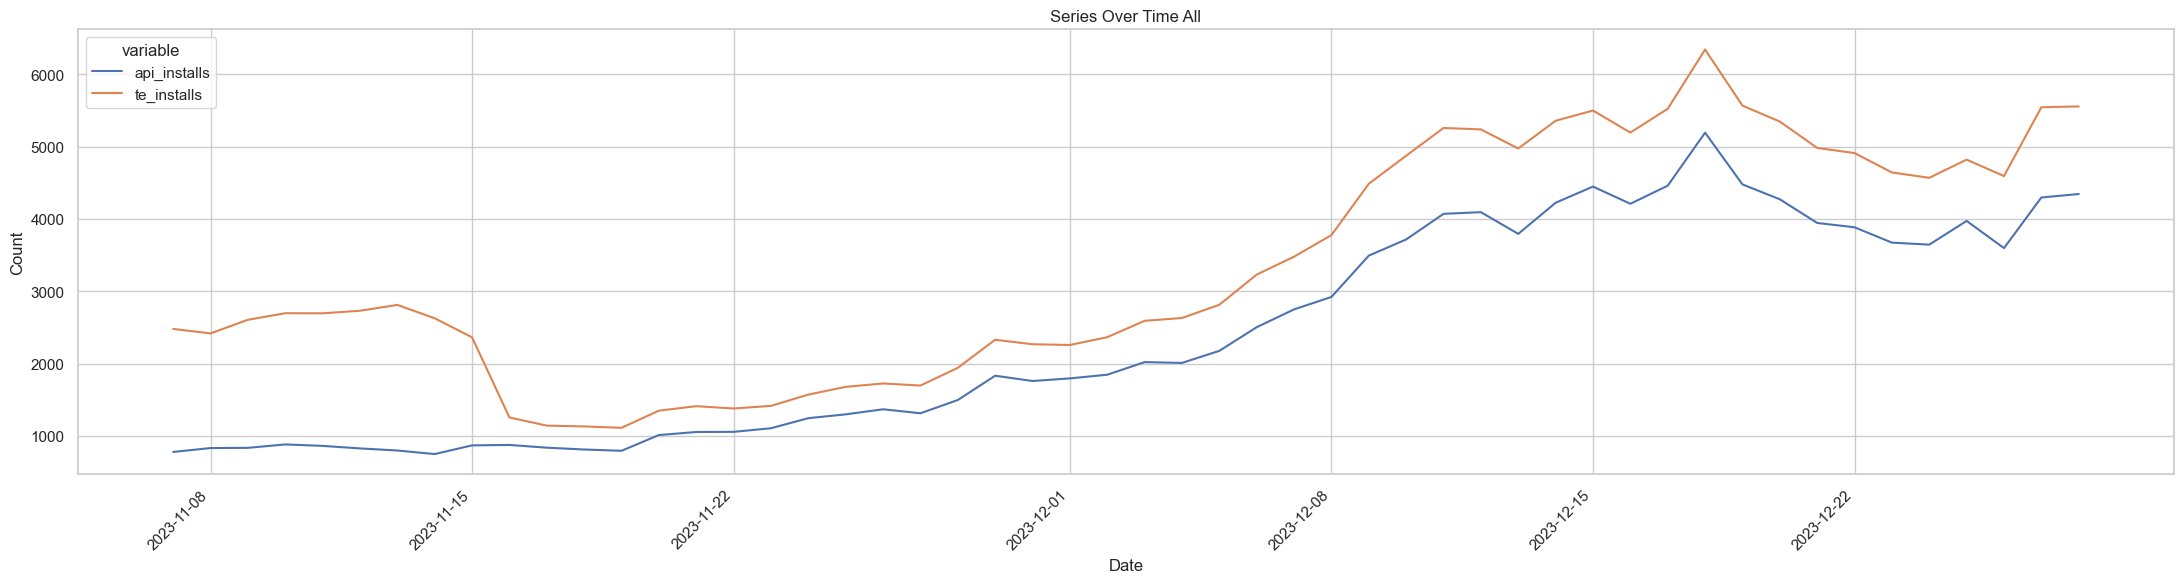

In [33]:

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['api_installs', 'te_installs'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time All')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

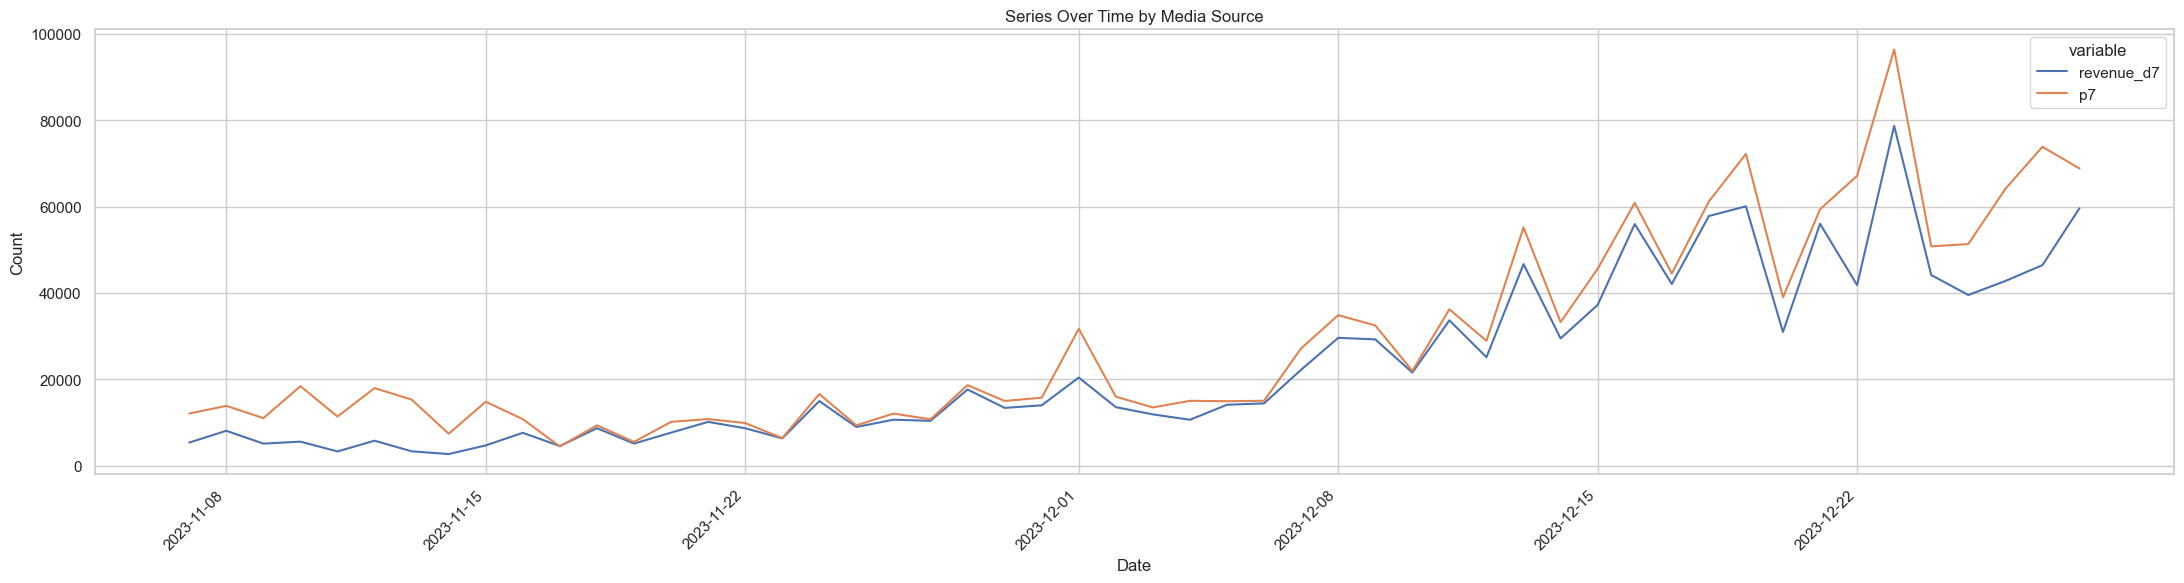

In [34]:
# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['revenue_d7', 'p7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

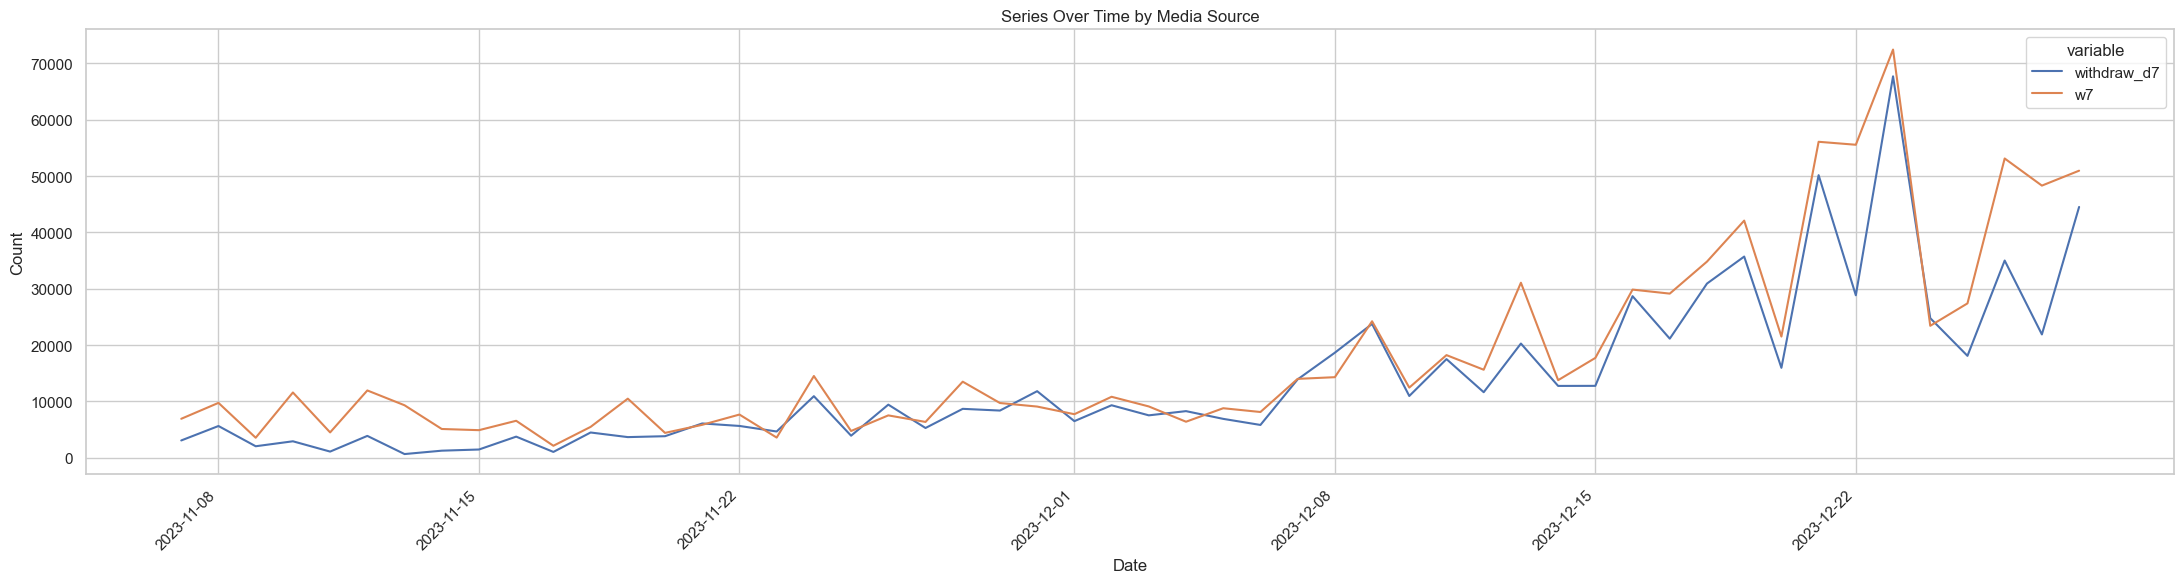

In [35]:
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['withdraw_d7', 'w7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

## 3. Incorporate the responses from the BI tool 

In [40]:
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126114811.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)

bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']

In [41]:
bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
71,20231108,"4,975.01 (36.28%)","7,668.44 (55.92%)","16,387.03 (119.5%)"
70,20231109,"2,298.62 (15.38%)","3,588.79 (24.01%)","4,962.28 (33.2%)"
69,20231110,"11,288.82 (69.2%)","25,256.77 (154.81%)","37,694.67 (231.05%)"
68,20231111,"2,622.44 (16.48%)","3,771.83 (23.71%)","9,822.25 (61.74%)"
67,20231112,"7,123.44 (42.87%)","10,995.05 (66.17%)","14,381.77 (86.56%)"
66,20231113,"2,641.14（15.98%）","4,017.01（24.31%）","5,039.40（30.5%）"
65,20231114,"2,633.08（15.81%）","3,847.72（23.11%）","4,954.05（29.75%）"
64,20231115,"1,956.68（11.26%）","2,283.08（13.14%）","3,897.57（22.44%）"
63,20231116,"2,587.26（16.46%）","4,044.17（25.72%）","5,351.50（34.04%）"
62,20231117,"3,549.81（19.97%）","4,594.79（25.85%）","6,578.70（37.01%）"


In [42]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

for col in ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
71,20231108,0.3628,0.5592,1.1950
70,20231109,0.1538,0.2401,0.3320
69,20231110,0.6920,1.5481,2.3105
68,20231111,0.1648,0.2371,0.6174
67,20231112,0.4287,0.6617,0.8656
66,20231113,0.1598,0.2431,0.3050
65,20231114,0.1581,0.2311,0.2975
64,20231115,0.1126,0.1314,0.2244
63,20231116,0.1646,0.2572,0.3404
62,20231117,0.1997,0.2585,0.3701


In [43]:
bi_tool_actuals['date'].max()
# bi_tool_actuals['date'].dtype

20240118

In [24]:
# MERGE BI TOOL TO MY DATA (AGG DF INCLUDES BI DATA)

bi_tool_wanted_cols = ['date', 'Recovery on the 28th (rate)']

# agg_df['channel'] = agg_df['media_source']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
agg_df = pd.merge(agg_df, bi_tool_actuals[bi_tool_wanted_cols], on = 'date')
agg_df.sample(10)


,date,api_installs,cost,revenue_d7,withdraw_d7,p1,p10,p100,p105,p11,...,pred_26_133,pred_27_133,pred_28_133,pred_35_133,te_installs,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate)
45,20231213,1371,33124.70,7118.55,2543.25,2662.15431,12860.33303,41283.69232,41283.69232,13535.09224,...,2.828831,2.897791,2.805545,3.141404,1656,-0.163845,4.192232,-0.172101,0.357271,0.5575
26,20231124,1085,23417.13,2869.86,864.68,975.17478,3550.02703,29836.43448,29836.43448,3771.90966,...,1.816122,1.837705,1.885557,2.293819,1282,-0.032415,1.645032,-0.153666,0.301297,0.1908
29,20231127,1299,25645.28,4561.63,1143.42,1950.98998,5695.36793,20820.80594,20820.80594,6062.80356,...,1.313106,1.295382,1.220269,1.381953,1518,0.055693,2.511647,-0.144269,0.250660,0.3492
49,20231217,1137,31540.05,3281.35,736.79,1716.16373,4638.64708,15918.30281,15918.30281,5003.79471,...,1.600666,1.614135,1.532664,1.551533,1390,-0.059755,1.885972,-0.182014,0.224539,0.1836
1,20231030,605,10158.87,1674.85,485.41,628.87015,1776.24825,11519.05851,11519.05851,1876.38883,...,0.952914,1.026912,0.975149,1.079020,738,0.291874,1.768347,-0.180217,0.289823,0.2781
37,20231205,1469,31137.36,5105.22,1748.62,2494.92593,6815.33787,31116.42411,31116.42411,7298.02397,...,1.193017,1.204039,1.234281,1.513614,1779,-0.041953,2.475303,-0.174255,0.342516,0.3338
21,20231119,1348,22010.59,8517.65,1270.36,2071.69152,11796.17856,70219.27796,70219.27796,12953.91919,...,2.699826,2.872190,2.923490,3.833478,1570,-0.131660,5.318731,-0.141401,0.149144,0.9932
13,20231111,925,16688.19,3464.21,1204.15,1031.85026,5482.84888,41800.33429,41800.33429,5606.55404,...,2.404345,2.656606,2.602957,3.109607,1093,-0.157713,2.745092,-0.153705,0.347597,0.6174
6,20231104,810,14921.47,3523.87,318.95,1357.39378,3621.93441,16040.77450,16040.77450,3744.55841,...,1.036229,1.133306,1.131727,1.311372,976,0.013839,3.350457,-0.170082,0.090511,0.4928
4,20231102,829,15394.49,2742.50,369.41,839.56078,5543.36962,18267.27786,18267.27786,6031.43662,...,1.647325,1.648552,1.667445,1.837944,978,-0.363490,2.308203,-0.152352,0.134698,0.5009


### Check the Joint results

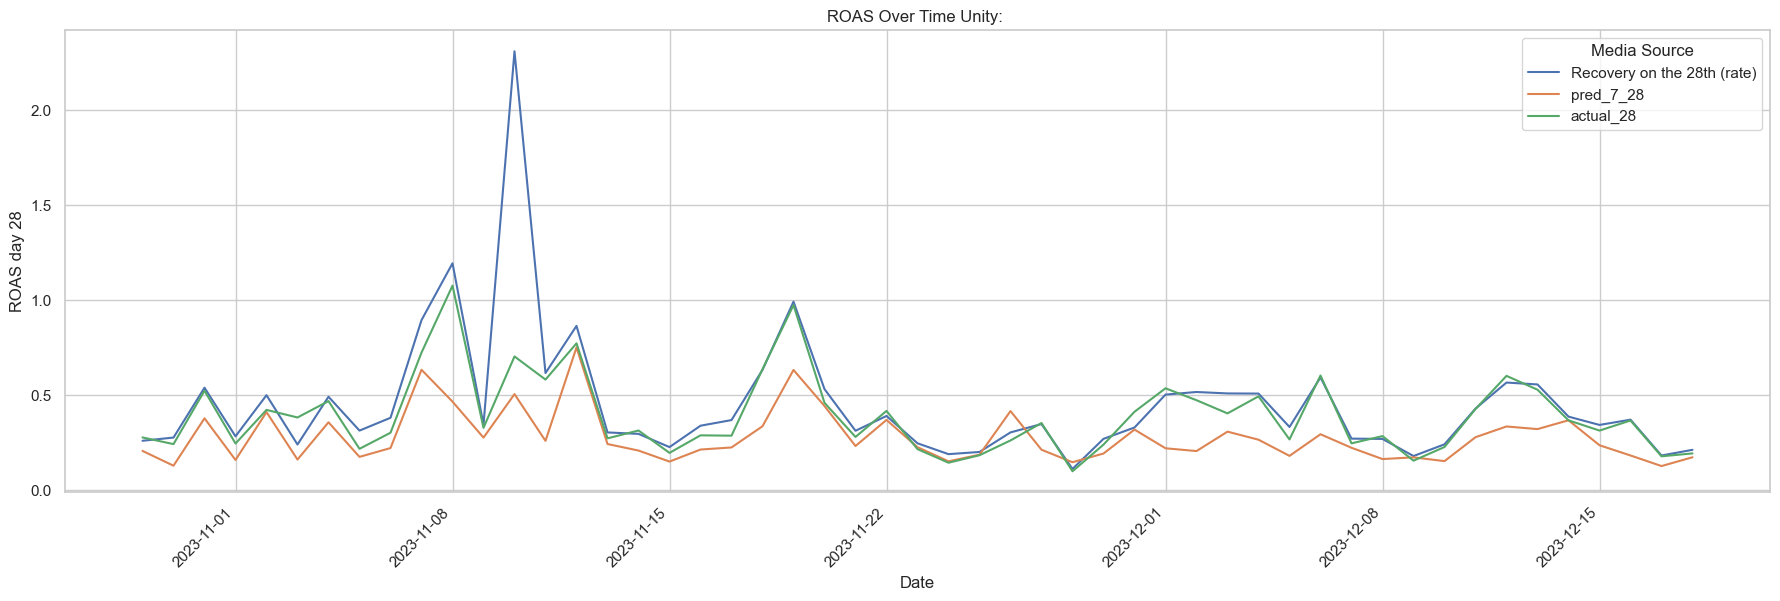

In [25]:

# sourcesito = 'unityads_int'

filtered_df = agg_df.copy()#[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Find the best configuration to train correction rule

In [26]:
w_col_names = [col for col in agg_df.columns if re.match(r'^w\d*$', col) is not None]
p_col_names = [col for col in agg_df.columns if re.match(r'^p\d*$', col) is not None]
agg_df_train = agg_df[agg_df['api_installs'] > 50][['date'] + ['te_installs'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] 
                        + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] + ['Recovery on the 28th (rate)']
                        + [col for col in agg_df.columns if col.startswith("pred_") ] + w_col_names + p_col_names]

agg_df_train['d7_28_increase_api'] = agg_df_train['Recovery on the 28th (rate)'] - agg_df_train['revenue_d7']/agg_df_train['cost']
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])


In [27]:
# GET THE COLUMN GROUPS
validation_sets = 3
agg_df_train['validation_set_id'] = pd.qcut(agg_df_train['date'].astype(float).values, validation_sets)

In [28]:
agg_df_train.groupby('validation_set_id').size()

validation_set_id
(20231028.999, 20231114.667]    17
(20231114.667, 20231201.333]    17
(20231201.333, 20231218.0]      17
dtype: int64

In [29]:
# Check for nulls, infinities and select the model_cols
model_cols = agg_df_train[agg_df_train.columns[5:]].columns
model_cols
null_rows = agg_df_train[agg_df_train['payment_increase'].isnull()]
print(null_rows)
infinity_rows = agg_df_train[np.isinf(agg_df_train['payment_increase'])]
infinity_rows

Empty DataFrame
Columns: [date, te_installs, cost, revenue_d7, withdraw_d7, payment_increase, rpi_increase, installs_difference, withdrawn_ratio, Recovery on the 28th (rate), pred_7_14, pred_8_14, pred_9_14, pred_10_14, pred_11_14, pred_12_14, pred_13_14, pred_7_28, pred_8_28, pred_9_28, pred_10_28, pred_11_28, pred_12_28, pred_13_28, pred_14_28, pred_15_28, pred_16_28, pred_17_28, pred_18_28, pred_19_28, pred_20_28, pred_21_28, pred_22_28, pred_23_28, pred_24_28, pred_25_28, pred_26_28, pred_27_28, pred_7_56, pred_8_56, pred_9_56, pred_10_56, pred_11_56, pred_12_56, pred_13_56, pred_14_56, pred_15_56, pred_16_56, pred_17_56, pred_18_56, pred_19_56, pred_20_56, pred_21_56, pred_22_56, pred_23_56, pred_24_56, pred_25_56, pred_26_56, pred_27_56, pred_28_56, pred_35_56, pred_7_63, pred_8_63, pred_9_63, pred_10_63, pred_11_63, pred_12_63, pred_13_63, pred_14_63, pred_15_63, pred_16_63, pred_17_63, pred_18_63, pred_19_63, pred_20_63, pred_21_63, pred_22_63, pred_23_63, pred_24_63, pred_25_6

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,p70,p77,p8,p84,p9,p91,p98,d7_28_increase_api,d7_28_increase_pred,validation_set_id


### Modelling

In [30]:
# Define predictive model and the polynomial transformation (This should be kept for the dictionary with the exception of the dynamic column. In this case: d7_28_increase_pred)

## Model cols

## Addition
agg_df_train['return_withdraw_d7'] = agg_df_train['withdraw_d7'] / agg_df_train['cost'] 
agg_df_train['return_p_d7'] = agg_df_train['p7'] / agg_df_train['cost'] 

## Definintion in list 
model_cols = ['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase', 'installs_difference', 'withdrawn_ratio', 'd7_28_increase_api', 'd7_28_increase_pred', 'te_installs']

## Algorithm 
def create_huber(alpha, epsi, cols, weights_train): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )


    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept = True, epsilon = epsi, alpha = alpha, warm_start = False, max_iter = 1000))
    ])

    pipe.named_steps['regressor'].sample_weight = weights_train

    return pipe

## Feat engineering
def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data


In [31]:
model_results = []
all_model_results = []
alphas = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2] 
epsils = [1, 1.05, 1.1, 1.3, 1.5, 1.7, 2, 2.5, 3] 

# for train_index, test_index in splits:
for date_group in tqdm(agg_df_train['validation_set_id'].unique()):
    
    print(date_group)

    train_data =  agg_df_train[agg_df_train['validation_set_id'] != date_group][model_cols]
    test_data =  agg_df_train[agg_df_train['validation_set_id'] == date_group][model_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increase_api']), train_data[f'd7_28_increase_api'] 
    X_test, y_test = test_data.drop(columns = [f'd7_28_increase_api']), test_data[f'd7_28_increase_api']

    old_cols = X_train[[col for col in X_train.columns if col != 'te_installs']].copy().columns
    X_train = all_feature_enginerring(X_train, 'd7_28_increase_pred')
    X_test = all_feature_enginerring(X_test, 'd7_28_increase_pred')

    weights_train = np.log1p(X_train['te_installs'])

    for alpha in alphas: 
        for epsi in epsils: 
            for cols in [old_cols, X_train.columns]:
                
                # Full trainning and testing 
                model = create_huber(alpha, epsi, old_cols, weights_train)
                model.fit(X_train[[col for col in cols if col != 'te_installs']], y_train)
                predictions = model.predict(X_test[[col for col in X_train.columns if col != 'te_installs']])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len([col for col in cols if col != 'te_installs']))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)
all_model_results.shape[0]


  0%|          | 0/3 [00:00<?, ?it/s]

(20231028.999, 20231114.667]


 33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

(20231114.667, 20231201.333]


 67%|██████▋   | 2/3 [00:04<00:02,  2.51s/it]

(20231201.333, 20231218.0]


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


864

In [32]:
all_model_results.sort_values(by = 'mae').head(5)

,Iteration,Test at,Model,mae,r2,rel_mae
736,0 - 3 - 7,"(20231201.333, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.071873,0.246702,0.279445
754,0.005 - 3 - 7,"(20231201.333, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.071875,0.246542,0.279424
772,0.01 - 3 - 7,"(20231201.333, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.071877,0.246381,0.279404
790,0.02 - 3 - 7,"(20231201.333, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.071881,0.246059,0.279363
808,0.05 - 3 - 7,"(20231201.333, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.071893,0.245090,0.279241


In [33]:
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'mae', ascending = True).head(10)

,mae,r2,rel_mae
Iteration,,,
0.05 - 1.05 - 10,0.139712,0.216797,0.228476
0.01 - 1.05 - 10,0.139805,0.218616,0.227292
0.2 - 1.3 - 7,0.139970,0.226613,0.227826
0.2 - 1.3 - 10,0.140020,0.225516,0.227536
0.05 - 1.05 - 7,0.140022,0.213705,0.225402
0.15 - 1.3 - 7,0.140056,0.225389,0.227058
0.15 - 1.3 - 10,0.140120,0.223934,0.226687
0.1 - 1.3 - 7,0.140143,0.224150,0.226281
0.05 - 1.3 - 7,0.140232,0.222879,0.225489


In [40]:
# def all_feature_enginerring(data, pred_col):

#     """
#     This is better to create before and the just utilise it in whatever model
#         - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
#     """
    
#     # Inclusion of interpolation 
#     column_list = ['withdrawn_ratio', pred_col, 'installs_difference']
#     column_combinations = list(itertools.combinations(column_list, 2))

#     for pair in column_combinations:
#         column1, column2 = pair
#         new_column_name = f"{column1}_times_{column2}"
#         data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

#     return data

In [34]:
model_value = all_model_results.loc[all_model_results['Iteration'] == '0.2 - 1 - 10', 'Model'].iloc[0]
reset_df_plus = all_feature_enginerring(agg_df_train, 'd7_28_increase_pred')
cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_7_28',
    'roas_d7_times_pred_7_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_7_28_times_installs_difference'
]
cols_to_append = [
    'withdrawn_ratio_times_d7_28_increase_pred',
    'withdrawn_ratio_times_installs_difference',
    'd7_28_increase_pred_times_installs_difference']

subnormal = [col for col in old_cols if col != 'Installs']
subnormal.extend(cols_to_append)

predictions = model_value.predict(reset_df_plus[subnormal])

In [35]:
import pandas as pd
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': (agg_df_train['revenue_d7']/agg_df_train['cost']), 'installs': agg_df_train['te_installs']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs ROAS day 7', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [36]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs']})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [37]:
pdf = pd.DataFrame({'y_test': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + agg_df_train['d7_28_increase_api'].values), 'predictions': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + predictions)})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test']
                )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

## Fit to dictionary based on availables

In [38]:
dev_df = agg_df_train.copy(deep = True)

columns_rule = ['revenue_d7','withdraw_d7','installs','payment_increase','rpi_increase','installs_difference','is_facebook','pred_roas','roas_d7','withdrawn_ratio']
columns_rule = ['revenue_d7','withdraw_d7','payment_increase','rpi_increase','installs_difference']

max_date = df['date'].max()
dev_df['days_since_install'] = (max_date - dev_df['date']) # Needed? Yes


In [39]:
payback_predictive_system = []

from tqdm import tqdm, tqdm_notebook

for y_day in tqdm(['14', '28']):
  for x_day in predictors_days:
    if int(y_day) > int(x_day):
  
      train = dev_df.copy()
      train['y'] = train['Recovery on the 28th (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'])/train['cost']
      y = train[train['days_since_install'] <= (int(y_day) - 1)]['y'] # This is the regressors-based of d7_28_increment
      del train['y']
  
      # Make the regressors
      selected_columns = columns_rule + [f'pred_{x_day}_{y_day}']
      
      # Define X 
      X = train[train['days_since_install'] <= (int(y_day) - 1)]
      weights_train = np.log1p(X['te_installs'])
  
      # Define observation importance 0.01 - 1.05 - 160 - 1 - 10
      model = create_huber(0.0, 1.05, selected_columns, weights_train)
      model.fit(X[[col for col in selected_columns if col != 'te_installs']], y)
  
      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X[[col for col in selected_columns if col != 'te_installs']].columns]
              })
  
      payback_predictive_system.append(payback)

rules_dict = pd.concat(payback_predictive_system, ignore_index = True)
rules_dict

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
5,12,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
6,13,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
7,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
8,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
9,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."


In [40]:
rules_dict['Columns'][12]

# 'Recovery on the 28th (rate)'
#  d7_28_increase_api



Index(['revenue_d7', 'withdraw_d7', 'payment_increase', 'rpi_increase',
       'installs_difference', 'pred_12_28'],
      dtype='object')

In [41]:
dev_df_check = dev_df.copy(deep = True)

In [42]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:

        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                                
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop = True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
    
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop = True).values[0]
    
                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}_agg'] = prediction + (data[f'p{reg}']- data[f'w{reg}'])/data[f'cost']
                
    return data

dev_df_check = add_predictions(dev_df_check, rules_dict, ['28'], predictors_days_input)


In [43]:
dev_df_check.sample(6)

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,pred_18_28_agg,pred_19_28_agg,pred_20_28_agg,pred_21_28_agg,pred_22_28_agg,pred_23_28_agg,pred_24_28_agg,pred_25_28_agg,pred_26_28_agg,pred_27_28_agg
39,20231207,1715,33283.19,6053.33,1006.56,0.041157,3.221290,-0.163848,0.166282,0.2724,...,0.272400,0.272400,0.272400,0.272400,0.272400,0.272400,0.273736,0.272403,0.272400,0.272400
41,20231209,1540,32042.34,5468.45,2287.13,-0.018952,3.322885,-0.178571,0.418241,0.1808,...,0.252603,0.291842,0.276049,0.281756,0.271522,0.250710,0.255863,0.207660,0.229772,0.221287
37,20231205,1779,31137.36,5105.22,1748.62,-0.041953,2.475303,-0.174255,0.342516,0.3338,...,0.333800,0.333800,0.333799,0.333800,0.333800,0.333800,0.308971,0.282451,0.303379,0.322564
43,20231211,1779,33640.84,5587.87,413.13,-0.198025,2.678650,-0.146150,0.073933,0.4304,...,0.497391,0.449189,0.494786,0.480884,0.463355,0.481865,0.470486,0.448001,0.432660,0.460108
24,20231122,1387,22116.13,6111.16,1160.39,-0.150268,4.259174,-0.162221,0.189880,0.3917,...,0.604481,0.526923,0.517442,0.464921,0.432818,0.431295,0.428623,0.429638,0.446416,0.446864
15,20231113,1232,18181.96,3223.16,634.49,-0.041920,2.055128,-0.143669,0.196853,0.3050,...,0.442651,0.388334,0.374727,0.382318,0.367991,0.372706,0.352368,0.325542,0.313045,0.287332


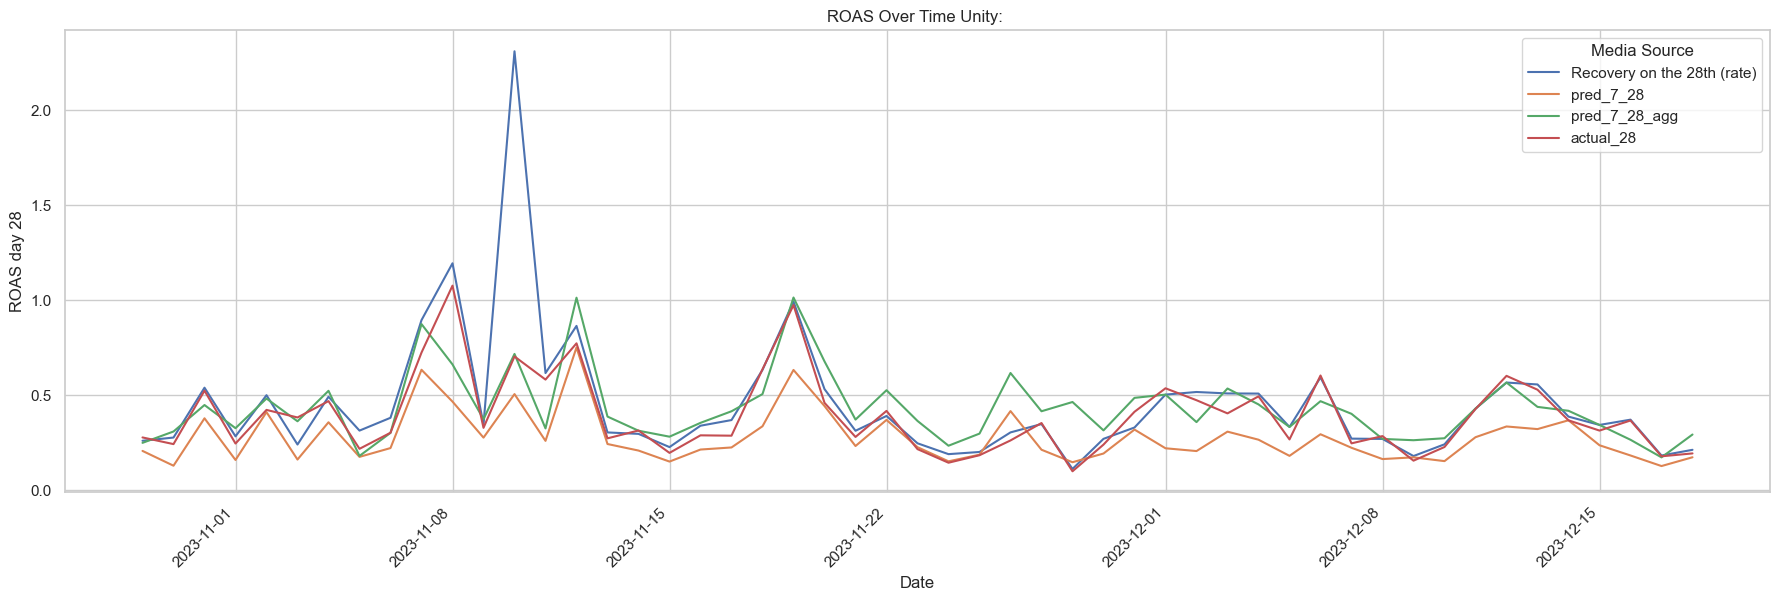

In [44]:
### Check the Joint results

filtered_df = dev_df_check.copy()
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by = 'date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [1]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('poker_party_ios_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(rules_dict, file)

NameError: name 'pickle' is not defined

In [107]:
# dev_df['pred_roas'] = dev_df['pred_7_28'] / dev_df['cost']
# dev_df['roas_d7'] = (dev_df['revenue_d7'] - dev_df['withdraw_d7']) / dev_df['cost']
# dev_df['withdrawn_ratio'] = dev_df['withdraw_d7'] / dev_df['revenue_d7']
# dev_df['d7_28_increment'] = dev_df['Recovery on the 28th (rate)'] - dev_df['roas_d7']

In [108]:
# # Functions
# # def gen_dates_and_df(source_df): 
# #     return result_df, unique_dates

# def filter_to_source_include_k(source_df, today): 
#     source_df['date'] = source_df.register_time.dt.normalize()
#     source_df['k'] = (today - source_df['date']).dt.days + 1 
#     return source_df

# today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))
# n_values = agg_df.columns[agg_df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
# available_k_values = [int(col.split('_')[1]) for col in agg_df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
# pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']
# pred_list

['pred_14',
 'pred_28',
 'pred_56',
 'pred_63',
 'pred_70',
 'pred_77',
 'pred_84',
 'pred_91',
 'pred_98',
 'pred_100',
 'pred_105',
 'pred_112',
 'pred_119',
 'pred_126',
 'pred_133']

In [109]:
# new_datasets = {}
# unique_values = agg_df['media_source'].unique()
# for value in unique_values:
#     new_datasets[value] = agg_df[agg_df['media_source'] == value].copy()